## Imports

In [1]:
import cv2
import glob
import pickle as pkl
from tqdm import tqdm
import matching_utils
import matplotlib.pyplot as plt

## Load detections

In [2]:
# Open the file in binary mode
seq = 'seq3'
cam = 'c15'

S = 'S03'
C = 'c015'

theshold = 0.25

with open(f'/home/group05/mcv-m6-2022-team5/week5/tracking_results/kalman_tracking_{seq}_{cam}_pp.pkl', 'rb') as file:
    # Call load method to deserialze
    detections = pkl.load(file)

video_path = f'/home/group05/mcv-m6-2022-team5/datasets/aic19-track1-mtmc-train/train/{S}/{C}/vdo.avi'

In [3]:
detections[1]

,frame,track,bbox,colour,size,detection,life


In [4]:
track_ids_df = matching_utils.init_global_track_ids_df()
model = matching_utils.get_metric_learning_model()

Using cache found in /home/group05/.cache/torch/hub/pytorch_vision_v0.10.0


# Detections to global df

In [117]:
vidcap = cv2.VideoCapture(video_path)

_, _ = vidcap.read()

for detection in tqdm(detections):
    _, image = vidcap.read()
    if type(image) != type(None):
        for index, row in detection.iterrows():
            if not row['track'] in track_ids_df['track_ids'].unique():
                track_ids_df = matching_utils.add_global_track_ids(track_ids_df, image, row)
            else:
                img = matching_utils.get_detected_box_image(image, row['bbox'])

                index = track_ids_df.index[track_ids_df['track_ids'] == row['track']].tolist()[0]
                detection_frames_list = track_ids_df.loc[index, 'detection_frames']

                distances = []

                for detection_frame in detection_frames_list:
                    distances.append(matching_utils.get_metric_distance(model, img, detection_frame)[0][1])

                if min(distances) > theshold:
                    track_ids_df = matching_utils.update_global_track_id(track_ids_df, image, row)

pkl.dump(track_ids_df, open(f"./matching_results/track_ids_df_{S}_{C}.pkl", "wb"))

100%|██████████| 1928/1928 [00:11<00:00, 170.75it/s]


In [118]:
with open(f"./matching_results/track_ids_df_{S}_{C}.pkl",'rb') as openFile:
    track_ids_df = pkl.load(openFile)

track_ids_df

,track_ids,detection_frames
0,44,"[[[[133 145 150], [ 99 111 116], [104 116 121]..."
1,68,"[[[[170 174 162], [170 174 162], [170 174 162]..."
2,59,"[[[[162 159 153], [162 159 153], [162 158 148]..."
3,91,"[[[[147 149 142], [147 149 142], [149 153 141]..."


3


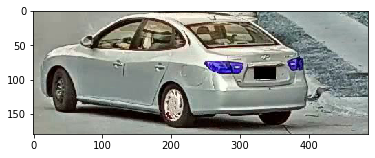

In [136]:
## good examples seq3-c013 7/8
index = 0
print(len(track_ids_df.loc[index,'detection_frames']))
plt.imshow(track_ids_df.loc[index,'detection_frames'][2])
plt.show()

# Global Matching

In [5]:
dfs = []

# load data
for file_name in glob.glob('/home/group05/mcv-m6-2022-team5/week5/matching_results/*'):
    with open(file_name,'rb') as openFile:
        global_track_ids_df = pkl.load(openFile)
        global_track_ids_df['global_track_ids'] = (global_track_ids_df['track_ids'])
        shiftPos = global_track_ids_df.pop("global_track_ids")
        global_track_ids_df.insert(0, "global_track_ids", shiftPos)
        dfs.append(global_track_ids_df)

In [6]:
global_track_ids_df = dfs[0]
global_track_ids_df

,global_track_ids,track_ids,detection_frames
0,14,14,"[[[[118 135 139], [109 126 130], [150 167 171]..."
1,17,17,"[[[[117 129 139], [132 144 154], [143 155 165]..."
2,20,20,"[[[[147 159 164], [140 152 157], [125 137 142]..."
3,27,27,"[[[[150 138 138], [152 140 140], [149 137 137]..."
4,31,31,"[[[[151 158 164], [144 151 157], [135 142 148]..."
5,33,33,"[[[[121 138 142], [128 145 149], [168 185 189]..."
6,37,37,"[[[[172 181 187], [155 164 170], [153 162 168]..."
7,46,46,"[[[[165 179 184], [164 178 183], [172 186 191]..."
8,61,61,"[[[[64 50 48], [65 51 49], [66 52 50], [67 53 ..."
9,74,74,"[[[[169 178 184], [178 187 193], [172 181 187]..."


In [1]:
def get_new_track_id(detections_pd):
    counter = 0

    while counter in detections_pd['track'].tolist():
        counter = counter + 1
    return counter

In [8]:
for i in range(1,5):
    for index, row in global_track_ids_df.iterrows():

        detection_frames_list = row['detection_frames']

        for detection_frame in detection_frames_list:
            for index2, row2 in dfs[i].iterrows():
                distances = []

                detection_frames_list2 = row2['detection_frames']
                for detection_frame2 in detection_frames_list2:
                    distances.append(matching_utils.get_metric_distance(model, detection_frame2, detection_frame)[0][1])

                # print(f'Track: {row["track_ids"]} - {index2}, distance:{min(distances)}')

                if min(distances) < 0.25:
                    dfs[i].at[index2, 'global_track_ids'] = row['track_ids']
                    # track_id = get_new_track_id(global_track_ids_df)
                    # row = {'track_ids': track_id, 'detection_frames': detection_frames_list2}
                    # global_track_ids_df = global_track_ids_df.append(row,ignore_index=True)

    #     break
    # break

In [9]:
dfs[1]

,global_track_ids,track_ids,detection_frames
0,80,1,"[[[[105 107 100], [103 105 98], [143 145 138]..."
1,2,2,"[[[[19 3 1], [16 0 0], [20 4 2], [22 6 ..."
2,80,3,"[[[[138 147 148], [138 147 148], [137 146 147]..."
3,33,5,"[[[[141 158 167], [134 149 158], [130 145 154]..."
4,61,7,"[[[[140 140 138], [147 147 145], [143 143 141]..."
5,33,10,"[[[[68 70 72], [74 73 75], [62 61 63], [43 45 ..."
6,12,12,"[[[[55 38 32], [82 65 59], [109 92 86], [56 ..."
7,46,4,"[[[[155 152 151], [155 152 151], [155 152 151]..."
8,80,8,"[[[[144 141 135], [143 140 134], [143 140 134]..."
9,74,17,"[[[[174 166 166], [176 168 168], [176 168 168]..."


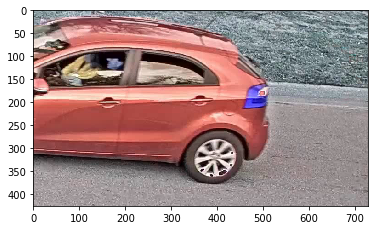

In [160]:
plt.imshow(detection_frame)

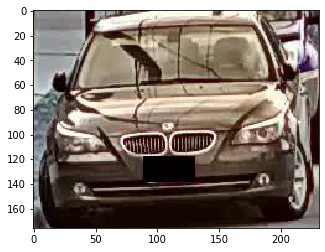

In [173]:
plt.imshow(dfs[1].loc[0, 'detection_frames'][0])